#### Import Libraries For Use

In [5]:
import sys 
sys.path.append('../') # important to adjust what path the libraries are loaded from
from modules.data.temporal import *
from modules.data.mixed import *
from modules.utils.pso import *
from modules.utils.train import *
from modules.utils.evaluate import *
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import numpy as np
import torch 
import matplotlib.pyplot as plt
import os
import pickle

### 1. Process Data from Generated Format Into Something Useful (i.e a pickle)

Let's define a function that's capable of reading files that do not have a uniform shape (i.e # of cols in first row is different than the # of cols in second row).

In [2]:
def get_data_inhomogenous(filename):
    # filename = 'your_file.txt'
    delimiter = '\t'  # Adjust this according to your file's format
    placeholder_value = np.nan  # Placeholder for missing values

    # Step 1: Read the file as a list of strings
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Step 2: Determine the maximum number of columns
    max_columns = max(len(line.split(delimiter)) for line in lines)

    # Step 4: Create a numpy array filled with the placeholder value
    data = np.empty((len(lines), max_columns))
    data.fill(placeholder_value)

    # Step 5: Iterate over the lines and fill the numpy array
    for i, line in enumerate(lines):
        values = line.strip().split(delimiter)
        data[i, :len(values)] = values                                                                                                   

    # Print the resulting numpy array
    # print(data.shape) 
    return data  

Next, we write some code that given some directories, reads every single data file and combines them into one data format. In this case, we choose a dictionary for its convenient (key,value) format that makes pickling more interpretable.

Get directories.

In [3]:
parent_dir = "../data/John_Indrani_data/zeta_Ca_signal/training_ca_pzap_h"
output_path = "../data/time_series/indrani_zeta_ca_h_no_zeroes.pickle"
parameter_dirs = [os.path.join(parent_dir,x) for x in os.listdir(parent_dir)]
print(parameter_dirs)

['../data/John_Indrani_data/zeta_Ca_signal/training_ca_pzap_h/train1900.txt', '../data/John_Indrani_data/zeta_Ca_signal/training_ca_pzap_h/train474_set0.txt', '../data/John_Indrani_data/zeta_Ca_signal/training_ca_pzap_h/train3296_set0.txt', '../data/John_Indrani_data/zeta_Ca_signal/training_ca_pzap_h/train2794_set0.txt', '../data/John_Indrani_data/zeta_Ca_signal/training_ca_pzap_h/train1409_set0.txt', '../data/John_Indrani_data/zeta_Ca_signal/training_ca_pzap_h/train1944_set0.txt', '../data/John_Indrani_data/zeta_Ca_signal/training_ca_pzap_h/train2137.txt', '../data/John_Indrani_data/zeta_Ca_signal/training_ca_pzap_h/train2866_set0.txt', '../data/John_Indrani_data/zeta_Ca_signal/training_ca_pzap_h/train3442_set0.txt', '../data/John_Indrani_data/zeta_Ca_signal/training_ca_pzap_h/train2845.txt', '../data/John_Indrani_data/zeta_Ca_signal/training_ca_pzap_h/train3342.txt', '../data/John_Indrani_data/zeta_Ca_signal/training_ca_pzap_h/train1905_set0.txt', '../data/John_Indrani_data/zeta_Ca_s

Read all data files into a single format.

In [4]:
rates = []
output = []
times = []
# please note that the first offset is to make sure we don't read in the 
for dir in parameter_dirs:
    if dir != parent_dir and ".txt" in dir and "train" in dir:
        data = get_data_inhomogenous(dir)
        rates.append(data[0])
        output.append(data[1:,1:4])
        
        if len(times) < 1:
            times = data[1:,0] # keep for plotting
            

Convert into PyTorch tensors (that is used for ML training) for saving.

In [5]:
# save into tensors and a dictionary
tosave = {}
rates_tensors = []
output_tensors  = []
for i in range(len(rates)):
    if np.sum(output[i]) > 0:
        # print("rates:",rates[i].shape)
        rates_tensors.append(torch.from_numpy(rates[i]))
        # print("output:", output[i].shape)
        output_tensors.append(torch.from_numpy(output[i]))    
            
tosave["rates"] = rates_tensors
tosave["outputs"] = output_tensors
tosave["time_points"] = times
print("# of Parameter Sets")
print(len(rates_tensors))
with open(output_path, 'wb') as handle:
    pickle.dump(tosave, handle, protocol=pickle.HIGHEST_PROTOCOL)

# of Parameter Sets
7559


### 2. Load data that will be used in training the surrogates and for computing which time points we want. Please look in modules/data/temporal for implementations of TemporalDataset class and modules/data/mixed for implementation of "static" datasets (i.e datasets that are of a single time point). 


In [10]:
dataset = TemporalDataset("../data/time_series/indrani_zeta_ca_h_no_zeroes.pickle", standardize_inputs=False, min_max_scale=False)

Dimensions of Trajectory:
torch.Size([2000, 3])


Quick example of how to access the dataset's time points, trajectories, and rate constants.

# of param sets: 7559


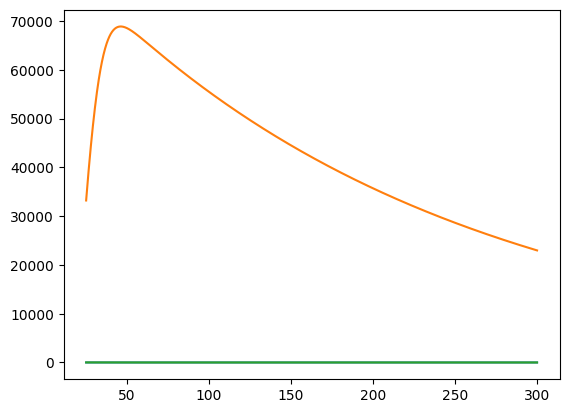

In [7]:
plt.plot(dataset.times, dataset.outputs[0]) # access outputs and time points with dataset.times and dataset.outputs[0]
print("# of param sets:", len(dataset.rates)) # access rates with dataset.rates

Normalizing and standardizing the dataset for training. This can take quite a bit of time in the jupyter notebook. It is generally much faster in a normal python script, to which there is a tutorial.py that you can play around with.

In [8]:
dataset = TemporalDataset("../data/time_series/indrani_zeta_ca_h_no_zeroes.pickle", standardize_inputs=True, min_max_scale=True)

Dimensions of Trajectory:
torch.Size([2000, 3])
Min Maxed Applied
Found Minimums: [2.58238907e-05 2.50413711e+03 3.35179254e-11]
Found Max: [3.37129568e-01 1.27032430e+05 1.00000000e+01]
Standardization to Input Parameters Applied
Found Mean Rates: [5.02756550e-03 5.45596962e+00 7.50186777e+03 5.44602143e+00
 5.03188747e-03]
With Std: [2.88437325e-03 2.59406368e+00 1.44695018e+03 2.60788633e+00
 2.85667423e-03]


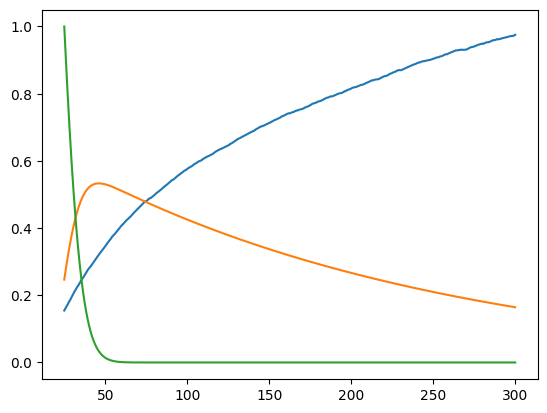

In [9]:
plt.plot(dataset.times, dataset.outputs[0])

Unnormalize again to showcase other features in the code.

In [11]:
dataset = TemporalDataset("../data/time_series/indrani_zeta_ca_h_no_zeroes.pickle", standardize_inputs=False, min_max_scale=False)

Dimensions of Trajectory:
torch.Size([2000, 3])


Take a slice out of the trajectories in the dataset. Note that the implementation of this function is in modules/data/temporal.

In [13]:
sliced = generate_static_dataset(dataset, t=333) # for the peak
sliced.write_to_csv("../data/static/indrani_tutorial_slice.csv") # write to directory

Load a static dataset for training purposes. Also, please note the normalization and standardization that happens. Take a look into modules/data/mixed for the implementation of ABMDataset

In [2]:
dataset = ABMDataset(csv_file="../data/static/indrani_tutorial_slice.csv", root_dir=None, standardize=True, norm_out=True) # Please note 

Standardization to Input Parameters Applied
Original Mean Inputs: [5.02756550e-03 5.45596962e+00 7.50186777e+03 5.44602143e+00
 5.03188747e-03]
Original Stds: [2.88437325e-03 2.59406368e+00 1.44695018e+03 2.60788633e+00
 2.85667423e-03]
New Average Input Value: [-4.20930066e-15 -1.75215195e-15 -3.61005342e-15 -2.85241690e-15
 -1.26335420e-15]
New Std Input Value: [1. 1. 1. 1. 1.]
max: 9999.887414217466
Normalization of Outputs
New Max: 1.0
New Min: 0.0


### 2.5. Split up training into train and test. 

In [3]:
train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size

# split dataset, into training set and test
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print("Length of training set:", len(train_dataset))
print("Length of test size:", len(test_dataset))


Length of training set: 6425
Length of test size: 1134


### 3. Run Training, please note I won't go into the time-series model training in this case, but it is in implementation very similar to training on a single time point, albeit different in model design. Please look in modules/utils/train.py for details on the implementation.

In [7]:
# hyperparameters
h_size = 128  # num of neurons per hidden layers
depth = 6 # number of layers 
nEpochs = 50 # how long to train for
batch_size = 200 # how many examples to train the neural network with in parallel
surrogate = train_nn(train_dataset, input_size = dataset.input_dim, output_size=dataset.out_dim, hidden_size=h_size, depth=depth, nEpochs=50,use_gpu=True, batch_size=batch_size)

Using GPU: True
Batch Size: 200
'Finished epoch 0 with loss 31.7253497344832 in time 0.46079134941101074'
'Finished epoch 10 with loss 2.901193799222637 in time 4.64064621925354'
'Finished epoch 20 with loss 0.94949132784076 in time 4.641572713851929'
'Finished epoch 30 with loss 0.5979506378213901 in time 4.645083665847778'
'Finished epoch 40 with loss 0.46023653038269235 in time 4.669729948043823'


### 4. Evaluate how good the training went. Please take a look in modules/utils/evaluate for the implementation.

In [9]:
avg_mse, time_to_run, predictions, truth = evaluate(surrogate, test_dataset, use_gpu=True, batch_size=batch_size)
print("Average Test MSE:", avg_mse)

Using GPU: True
Average Test MSE: 0.009004918348789543


### 5. Perform Parameter Estimation if in #4, it was proven sufficient. (in practice, getting to this step for parameter spaces is much harder)